<a href="https://colab.research.google.com/github/lianaling/ai-practical/blob/main/Copy_of_Back_to_Basics_03_BERT_Transformer_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers with TensorFlow

The original version of this notebook - https://colab.research.google.com/drive/1er3eOUILQ5MOB2Uzh1lntiDiK92DfvO4?usp=sharing



In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-efb061fd-fb8c-fb7a-d39f-c5060c9f2fd9)


In [2]:
!pip -q install transformers

     |████████████████████████████████| 3.4 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 39.4 MB/s 
     |████████████████████████████████| 596 kB 47.2 MB/s 
     |████████████████████████████████| 61 kB 425 kB/s 
     |████████████████████████████████| 895 kB 43.0 MB/s 


In [3]:
# 2 Classes 
!wget -q https://www.dropbox.com/s/ma7aik3z7dbj4gg/meet_reviews_03.csv

# 5 class based on the 5 stars - try later
# !wget -q https://www.dropbox.com/s/gxjn9yqa6nd3ob1/meet_reviews_02.csv

2 Main parts:
- Tokenizer 
- Model

In [4]:
# imports 
import tensorflow as tf
import pandas as pd
import numpy as np

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification



In [5]:
ls

meet_reviews_03.csv  sample_data/


## Load up some App Reviews

In [6]:
# load data into a dataframe
df = pd.read_csv('meet_reviews_03.csv', encoding='utf-8', error_bad_lines=False)

In [7]:
# lets look at the shape of the data
df.shape

(3898, 3)

In [8]:

df.head()

,Unnamed: 0,content,score
0,0,Firstly i like this app very so much. But afte...,1
1,1,The reason behind giving only one star is the ...,1
2,2,Although this app is good but still i hate it....,1
3,3,Can't access any settings within this app from...,1
4,4,I have online classes I can't hear it nicely i...,1


In [9]:
df.tail()

,Unnamed: 0,content,score
3893,5293,Nice app,5
3894,5294,😡😡😡😡😡.,5
3895,5295,Thank you for this app,5
3896,5296,👌,5
3897,5297,Wow,5


In [10]:
df['score'].unique()

array([1, 5])

In [11]:
# Shuffle
df = df.sample(frac=1).reset_index(drop=True)

train_df = df[:3600][['content','score']]
valid_df = df[3600:][['content','score']]


In [12]:
train_df.shape

(3600, 2)

## Plot out some info

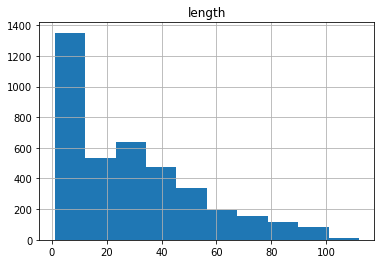

In [13]:
# review lengths
df['length'] = df['content'].apply(lambda x: len(x.split(' ')))

df.hist("length", bins=10);

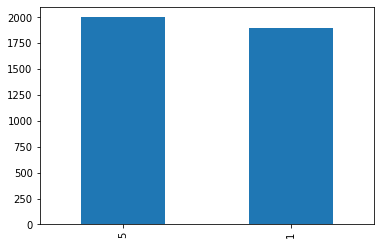

In [14]:
# checking amounts for each class
df['score'].value_counts().plot(kind='bar')

## Load the Model and Tokenizer

1.

In [17]:
# What model will we use?
model_name = 'bert-base-cased' # cased means handle upper and lower case. uncased means all data will be converted into lower case

# Load a tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)


# Load the model
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2) # number of output neurons

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
tokenizer.tokenize('Harry Potter was not an unfriendly wizard who was created by J.K.Rowling')

['Harry',
 'Potter',
 'was',
 'not',
 'an',
 'un',
 '##friend',
 '##ly',
 'wizard',
 'who',
 'was',
 'created',
 'by',
 'J',
 '.',
 'K',
 '.',
 'Row',
 '##ling']

#### Preparing the text

We need to get the text into a format so that we can pass it into the tokenizer

In [20]:
train_texts = train_df['content'].tolist()
valid_texts = valid_df['content'].tolist()

print(len(train_texts))
train_texts[:5]

3600


['Why suddenly the split screen in mobile is gone??...If we press the home button it goes to split in the screen..but suddenly i am not getting it',
 'This is a very good app for meeting purposes but the only problem I face that , the meeting cuts suddenly 😭...',
 'Please give more options',
 'Google Meet is better than zoom. It is now stable & easier to set up. No 45 min interruption to rejoin.',
 "I've been using this app from last two years and it's overall a very easy, wonderful and flexible app to use. I experienced very few problems at the start but clearing its cache and restarting it always helped and after that it never happened again. It's a really convenient and useful app for students who are attending online classes like us. Thank you Google for such an amazing app!"]

## Tokenizing, Padding and Truncating the text

In [21]:
# Pad the tokenizer outputs to the same length for all samples

# tokenize the training data
train_tokens = tokenizer(train_texts, 
                         max_length=128, 
                         truncation=True, 
                         padding='max_length', 
                         add_special_tokens=True,
                         return_token_type_ids=False,
                         return_tensors='tf')


# tokenize the validation data
valid_tokens = tokenizer(valid_texts, 
                         max_length=128, 
                         truncation=True, 
                         padding='max_length', 
                         add_special_tokens=True,
                         return_token_type_ids=False,
                         return_tensors='tf')



In [24]:
# Lets look at the tokens
tokenizer.special_tokens_map, tokenizer.cls_token_id, tokenizer.pad_token_id

({'cls_token': '[CLS]',
  'mask_token': '[MASK]',
  'pad_token': '[PAD]',
  'sep_token': '[SEP]',
  'unk_token': '[UNK]'},
 101,
 0)

In [25]:
# what did the tokenizer make?
train_tokens.keys()

dict_keys(['input_ids', 'attention_mask'])

In [26]:
# input_ids 
train_tokens['input_ids'][0]

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([ 101, 2009, 2840, 1103, 3325, 3251, 1107, 5093, 1110, 2065,  136,
        136,  119,  119,  119, 1409, 1195, 3181, 1103, 1313, 6324, 1122,
       2947, 1106, 3325, 1107, 1103, 3251,  119,  119, 1133, 2840,  178,
       1821, 1136, 2033, 1122,  102,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)>

In [27]:
# Attention masks
train_tokens['attention_mask'][0]

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

### Creating the Labels

In [29]:
# map the labels 
label_map = {1: 0, 5: 1}
label_map

{1: 0, 5: 1}

In [30]:
# Map the labels to our dictionary
train_labels = train_df['score'].map(label_map).values
valid_labels = valid_df['score'].map(label_map).values

In [32]:
# Lets check that 
row = 8

train_df['score'].iloc[row], train_labels[row]

(1, 0)

## Setting up the model

In [35]:
# optimizer
opt = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-8)

In [36]:
#loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # take in raw numbers of 0 and 1 and find one hot encoders because this model doesn't have a softmax layer
# from_logits=True means the output needs to be softmaxed
# compile the model
model.compile(optimizer=opt,
              loss=loss,
              metrics=['accuracy']
              )


In [37]:
# lets look at the model
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


In [38]:
# lets freeze the bert layer
model.layers[0].trainable = False # don't mess with the trained layers (many many layers hidden in one)

In [39]:
# lets look at the model again
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108,311,810
Trainable params: 1,538
Non-trainable params: 108,310,272
_________________________________________________________________


### Training

In [40]:
# train the model
model.fit(dict(train_tokens), train_labels, epochs=3, batch_size=16, validation_data=(dict(valid_tokens), valid_labels), verbose=1) # bigger model, smaller batches

Epoch 1/3
225/225 [==============================] - 266s 1s/step - loss: 0.5472 - accuracy: 0.7283 - val_loss: 0.4360 - val_accuracy: 0.8154
Epoch 2/3
225/225 [==============================] - 233s 1s/step - loss: 0.4278 - accuracy: 0.8211 - val_loss: 0.4534 - val_accuracy: 0.8054
Epoch 3/3
225/225 [==============================] - 232s 1s/step - loss: 0.3074 - accuracy: 0.8856 - val_loss: 0.4902 - val_accuracy: 0.8087


In [42]:
model.evaluate(dict(valid_tokens), valid_labels)

10/10 [==============================] - 6s 627ms/step - loss: 0.4902 - accuracy: 0.8087


[0.49016299843788147, 0.8087248206138611]

## Predictions

In [43]:
review = 'This app is pretty cool and has lots of good features'
# review = 'This app is pretty bad and has lots of awful features'

# review = "I really want to like this app but I can't for so many reasons"

In [45]:
review_tokens = tokenizer([review],
                         max_length=128, 
                         truncation=True, 
                         padding='max_length', 
                         add_special_tokens=True,
                         return_token_type_ids=False,
                         return_tensors='tf')

review_tokens

{'input_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[  101,  1188, 12647,  1110,  2785,  4348,  1105,  1144,  7424,
         1104,  1363,  1956,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

In [47]:
# PREDICTION 
pred = model.predict(dict(review_tokens))[0]

pred = tf.keras.activations.softmax((tf.constant(pred))).numpy() # need to softmax

pred

array([[0.23179707, 0.76820296]], dtype=float32)

In [48]:
# argmax out the result
np.argmax(pred, axis=-1)

array([1])

In [49]:
def get_model_layers(model):
    layers_temp = []
    layers = []
    weights = []
    params_total = 0
    for layer in model.layers:
        type_name = type(layer).__name__
        print(layer.name, type_name, layer.count_params())
        for i,sub in enumerate(layer.submodules):
            if sub.built:
                print(i+1, type(sub).__name__, sub.trainable, sub.count_params())
        # add params
        params_total += layer.count_params()

        #get the weights
        layer_wb = layer.get_weights()
        weights.append(layer_wb)

        # the raw weights
        layers_temp.append(layer)
    print(len(layers_temp))
    return layers,layers_temp, params_total

get_model_layers(model)

bert TFBertMainLayer 108310272
1 TFBertEmbeddings False 22665216
2 TFBertEncoder False 85054464
3 TFBertPooler False 590592
4 LayerNormalization False 1536
5 Dropout False 0
6 TFBertLayer False 7087872
7 TFBertLayer False 7087872
8 TFBertLayer False 7087872
9 TFBertLayer False 7087872
10 TFBertLayer False 7087872
11 TFBertLayer False 7087872
12 TFBertLayer False 7087872
13 TFBertLayer False 7087872
14 TFBertLayer False 7087872
15 TFBertLayer False 7087872
16 TFBertLayer False 7087872
17 TFBertLayer False 7087872
18 TFBertAttention False 2363904
19 TFBertIntermediate False 2362368
20 TFBertOutput False 2361600
21 TFBertSelfAttention False 1771776
22 TFBertSelfOutput False 592128
23 Dense False 590592
24 Dense False 590592
25 Dense False 590592
26 Dropout False 0
27 LayerNormalization False 1536
28 Dense False 590592
29 Dropout False 0
30 Dense False 2362368
31 LayerNormalization False 1536
32 Dense False 2360064
33 Dropout False 0
34 TFBertAttention False 2363904
35 TFBertIntermediate F

([],
 108311810)